# Data Dive 2

In [2]:
# Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from wordcloud import WordCloud


from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_absolute_percentage_error

from numpy import arange

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# Run once then comment out, if necessary
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
# to get sentiment, do: sia.polarity_scores(STRING)
# which will return a dict with keys "neg", "neu", "pos", and "compound"

print(pd.__version__)

2.0.3


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nicksartino/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
df= pd.read_csv('credit_card_complaints.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17433 entries, 0 to 17432
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date_received                 17433 non-null  int64  
 1   product                       17433 non-null  object 
 2   sub_product                   0 non-null      float64
 3   issue                         17433 non-null  object 
 4   sub_issue                     0 non-null      float64
 5   consumer_complaint_narrative  17433 non-null  object 
 6   company_public_response       8963 non-null   object 
 7   company                       17433 non-null  object 
 8   state                         17379 non-null  object 
 9   zip_code                      17379 non-null  object 
 10  tags                          2808 non-null   object 
 11  consumer_consent_provided     17433 non-null  object 
 12  submitted_via                 17433 non-null  object 
 13  d

In [5]:
df.describe()

,date_received,sub_product,sub_issue,date_sent_to_company,complaint_id
count,17433.000000,0.0,0.0,17433.000000,1.743300e+04
mean,42463.076866,NaN,NaN,42464.511329,1.864532e+06
std,207.296686,NaN,NaN,207.430956,3.117701e+05
min,42082.000000,NaN,NaN,42082.000000,1.290323e+06
25%,42285.000000,NaN,NaN,42285.000000,1.598380e+06
50%,42474.000000,NaN,NaN,42475.000000,1.879286e+06
75%,42643.000000,NaN,NaN,42644.000000,2.139726e+06
max,42829.000000,NaN,NaN,42829.000000,2.418474e+06


In [6]:
df.head(100)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id
0,42431,Credit card,NaN,Identity theft / Fraud / Embezzlement,NaN,- I am being pursued by U S Bank for fraudulen...,Company has responded to the consumer and the ...,U.S. Bancorp,AL,352XX,NaN,Consent provided,Web,42431,Closed with non-monetary relief,True,False,1813752
1,42694,Credit card,NaN,Rewards,NaN,- I opened an Amex credit card account in XXXX...,NaN,Amex,VA,231XX,NaN,Consent provided,Web,42695,Closed with non-monetary relief,True,True,2216897
2,42139,Credit card,NaN,Billing disputes,NaN,-- -- -- -- -- Forwarded message -- -- -- -- -...,NaN,Capital One,CA,920XX,NaN,Consent provided,Web,42143,Closed with explanation,True,True,1378763
3,42155,Credit card,NaN,Other fee,NaN,-- Price gauging with foreign transaction fees...,Company chooses not to provide a public response,Bank of America,NaN,NaN,NaN,Consent provided,Web,42155,Closed with monetary relief,True,False,1399288
4,42631,Credit card,NaN,Rewards,NaN,-I have filed a claim already and American Exp...,NaN,Amex,CO,805XX,NaN,Consent provided,Web,42631,Closed with non-monetary relief,True,False,2117687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,42094,Credit card,NaN,Billing disputes,NaN,30 day late payment assessed. Payment sent XXX...,Company chooses not to provide a public response,Synovus Bank,FL,328XX,NaN,Consent provided,Web,42094,Closed with non-monetary relief,True,True,1307908
96,42573,Credit card,NaN,Credit determination,NaN,30 days past.response not received. \nPlease r...,NaN,Capital One,CA,915XX,NaN,Consent provided,Web,42573,Closed with explanation,True,False,2024334
97,42360,Credit card,NaN,Identity theft / Fraud / Embezzlement,NaN,5th 3rd bank and affiliates continue to harass...,NaN,Fifth Third Financial Corporation,FL,339XX,NaN,Consent provided,Web,42360,Closed with explanation,True,False,1710693
98,42481,Credit card,NaN,Billing disputes,NaN,A {$500.00} purchase had been disputed with Bl...,Company has responded to the consumer and the ...,Citibank,CA,921XX,NaN,Consent provided,Web,42481,Closed with monetary relief,True,False,1889919


# What Questions are We Trying to Ask
* Company response vs various types of issues
* Most Hated company?
* Most Liked (heuristics)
* Sentiment analysis (maybe)
* Monetary compensation paid to unhappy customers

In [7]:
grouped = df.groupby('company_public_response')
grouped_count = grouped.size()
print(grouped_count)

company_public_response
Company believes complaint caused principally by actions of third party outside the control or direction of the company      10
Company believes complaint is the result of an isolated error                                                                54
Company believes complaint relates to a discontinued policy or procedure                                                      1
Company believes complaint represents an opportunity for improvement to better serve consumers                               17
Company believes it acted appropriately as authorized by contract or law                                                    372
Company believes the complaint is the result of a misunderstanding                                                           19
Company can't verify or dispute the facts in the complaint                                                                   11
Company chooses not to provide a public response                                

In [8]:
grouped = df.groupby('company')
grouped_count = grouped.size()
grouped_sum = grouped['complaint_id'].sum()
print(grouped_count)
print(grouped_sum)

company
APPLE RECOVERY, LLC              1
ARS National Services, Inc.      1
Acceptance Rentals, Inc.         1
Adir International, LLC          1
Affiliates Management Company    1
                                ..
Weltman, Weinberg & Reis         1
Whitney Bank                     1
ZENCO COLLECTION, LLC            1
Zions Bancorporation             1
Zwicker & Associates             1
Length: 205, dtype: int64
company
APPLE RECOVERY, LLC              1737384
ARS National Services, Inc.      2117648
Acceptance Rentals, Inc.         2186321
Adir International, LLC          1417716
Affiliates Management Company    2279929
                                  ...   
Weltman, Weinberg & Reis         1935917
Whitney Bank                     2317135
ZENCO COLLECTION, LLC            2101805
Zions Bancorporation             1315981
Zwicker & Associates             1934257
Name: complaint_id, Length: 205, dtype: int64


In [9]:
# sentiment_df = df.apply(lambda row: sia.polarity_scores(row["consumer_complaint_narrative"]), axis='rows')
#df["consumer_complaint_narrative"].apply(lambda val : sia.polarity_scores(val)["neg"])

In [10]:
df['consumer_complaint_score'] = df["consumer_complaint_narrative"].apply(lambda val : sia.polarity_scores(val)["neg"])

In [11]:
# Create 'new_date' column which is a floating point version of the string 'date_sent_to_company'

df['new_date'] = df['date_sent_to_company'].apply(float)

# This loop is used to create a Pandas timestamp from the excel formatted date from the data.  We are using an older version of Pandas so the method for each row is using the previously created float date as an offset that gets added to the date '1899-12-30' 

excel_dates = []

for row in df['new_date']:
    pandas_date = pd.to_datetime('1899-12-30') + pd.DateOffset(days=row)
    excel_dates.append(pandas_date)
df['excel_date'] = excel_dates
df = df.drop('new_date',axis=1)

df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id,consumer_complaint_score,excel_date
0,42431,Credit card,NaN,Identity theft / Fraud / Embezzlement,NaN,- I am being pursued by U S Bank for fraudulen...,Company has responded to the consumer and the ...,U.S. Bancorp,AL,352XX,NaN,Consent provided,Web,42431,Closed with non-monetary relief,True,False,1813752,0.171,2016-03-02
1,42694,Credit card,NaN,Rewards,NaN,- I opened an Amex credit card account in XXXX...,NaN,Amex,VA,231XX,NaN,Consent provided,Web,42695,Closed with non-monetary relief,True,True,2216897,0.033,2016-11-21
2,42139,Credit card,NaN,Billing disputes,NaN,-- -- -- -- -- Forwarded message -- -- -- -- -...,NaN,Capital One,CA,920XX,NaN,Consent provided,Web,42143,Closed with explanation,True,True,1378763,0.100,2015-05-19
3,42155,Credit card,NaN,Other fee,NaN,-- Price gauging with foreign transaction fees...,Company chooses not to provide a public response,Bank of America,NaN,NaN,NaN,Consent provided,Web,42155,Closed with monetary relief,True,False,1399288,0.036,2015-05-31
4,42631,Credit card,NaN,Rewards,NaN,-I have filed a claim already and American Exp...,NaN,Amex,CO,805XX,NaN,Consent provided,Web,42631,Closed with non-monetary relief,True,False,2117687,0.041,2016-09-18


In [12]:
# Create Month column for grouping

months = []

for index, row in df.iterrows():
    month = row['excel_date'].month
    months.append(month)
    
df['month'] = months
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zip_code,...,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,complaint_id,consumer_complaint_score,excel_date,month
0,42431,Credit card,NaN,Identity theft / Fraud / Embezzlement,NaN,- I am being pursued by U S Bank for fraudulen...,Company has responded to the consumer and the ...,U.S. Bancorp,AL,352XX,...,Consent provided,Web,42431,Closed with non-monetary relief,True,False,1813752,0.171,2016-03-02,3
1,42694,Credit card,NaN,Rewards,NaN,- I opened an Amex credit card account in XXXX...,NaN,Amex,VA,231XX,...,Consent provided,Web,42695,Closed with non-monetary relief,True,True,2216897,0.033,2016-11-21,11
2,42139,Credit card,NaN,Billing disputes,NaN,-- -- -- -- -- Forwarded message -- -- -- -- -...,NaN,Capital One,CA,920XX,...,Consent provided,Web,42143,Closed with explanation,True,True,1378763,0.100,2015-05-19,5
3,42155,Credit card,NaN,Other fee,NaN,-- Price gauging with foreign transaction fees...,Company chooses not to provide a public response,Bank of America,NaN,NaN,...,Consent provided,Web,42155,Closed with monetary relief,True,False,1399288,0.036,2015-05-31,5
4,42631,Credit card,NaN,Rewards,NaN,-I have filed a claim already and American Exp...,NaN,Amex,CO,805XX,...,Consent provided,Web,42631,Closed with non-monetary relief,True,False,2117687,0.041,2016-09-18,9


In [13]:
# Create the average sentiment over each month using group by

grouped_month = df.groupby(df['excel_date'].dt.to_period('M'))
average_sentiment = grouped['consumer_complaint_score'].mean()


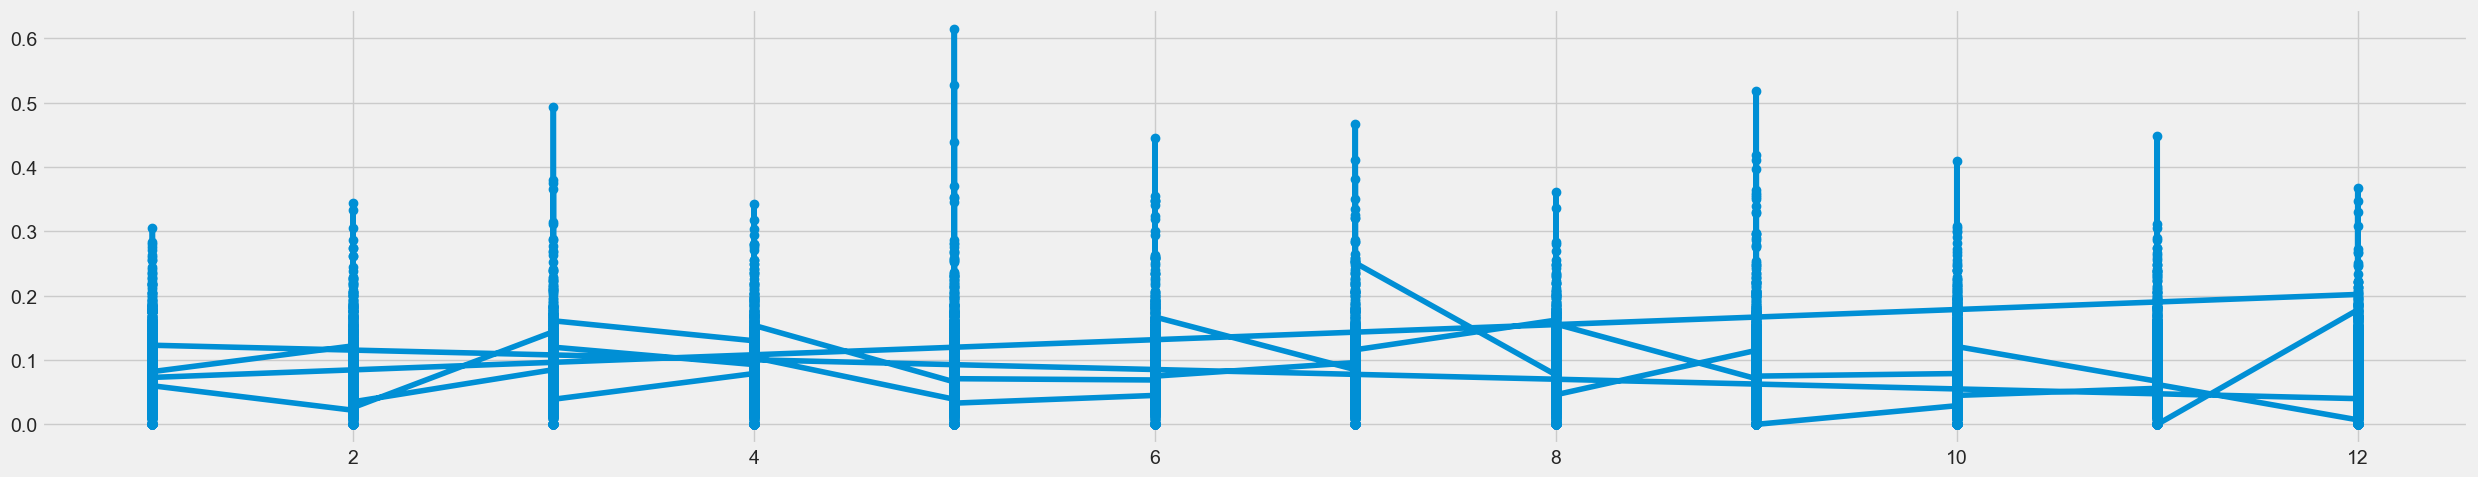

In [14]:
# Plot sentiment over excel date column

df.sort_values(by='excel_date', inplace=True)

plt.figure(figsize=(25,5))
plt.plot(df['month'], df['consumer_complaint_score'], marker = 'o')

plt.grid(True)
plt.tight_layout()

plt.show()

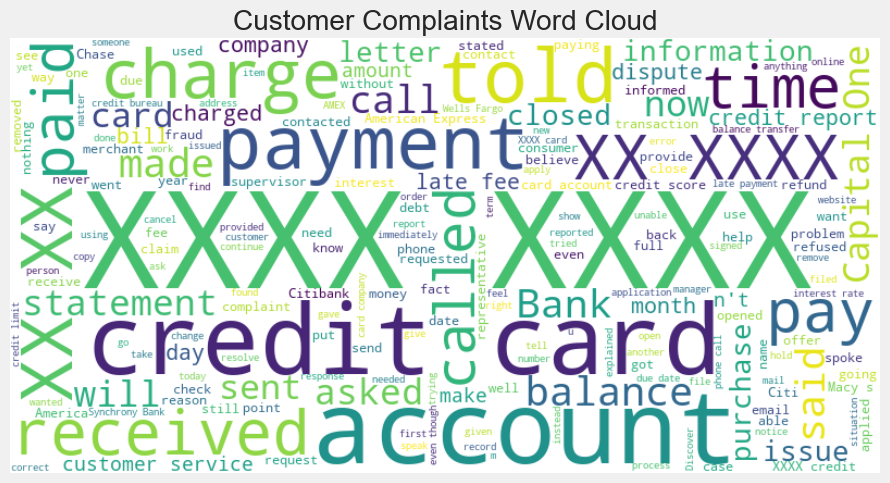

In [16]:
# Word Map of customer complaints

text = " ".join(complaint for complaint in df['consumer_complaint_narrative'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Customer Complaints Word Cloud")
plt.show()